In [73]:
import pandas as pd
from get_comments import main
from path import Path
import os
import time
from tqdm.auto import tqdm
import numpy as np

In [37]:
df = pd.read_csv('./data/change_org_petitions_Amber_Heard_at_20211005-222550_limit_1000_offset_0_delay_ms_500.csv')
df_status = pd.read_csv('./data/all_petitions_status_manual.csv')

In [45]:
slug_to_status = dict(zip(df_status.slug, df_status.status))

In [46]:
slugs = list(df['petition__slug'])
slugs = [x for x in slugs if isinstance(x, str)]
slugs = [x for x in slugs if slug_to_status[x] != 'irrelevant']

In [48]:
len(slugs)

183

In [ ]:
error_slugs = set()
for slug in tqdm(slugs):
    if not isinstance(slug, str):
        continue
    args = type('obj', (object,), {'petition_slug': slug, 'delay_ms': 100, 'offset': 0, 'limit': 1000000})
    with Path('./data'):
        try:
            main(args)
        except Exception as e:
            print(slug, e)
            error_slugs.add(slug)

In [51]:
# first two are not relevant
# the second one does not have public milestones
error_slugs

{'warner-brothers-get-johnny-depp-his-role-in-fantastic-beasts-back-arrest-fire-amber-heard-from-aquaman-2'}

In [52]:
# merging everything into a single dataframe

In [74]:
l = os.listdir('./data')
fs = []
prefix = 'change_org_comments_petition_slug_'
for filename in l:
    f = os.path.basename(filename)
    
    if not(filename.startswith(prefix) and filename.endswith('.csv')):
        continue
    slug = f[len(prefix):f.index('_limit_')]
    # print(slug)
    if slug not in slugs:
        continue
    fs.append('./data/' + filename)

In [67]:
def read_set_slug(f):
    try:
        df = pd.read_csv(f)
        slug = os.path.basename(f)[len(prefix):f.index('_limit_') + 1]
        df['petition__slug'] = [slug] * len(df)
        return df
    except:
        return None

In [68]:
df = pd.concat([read_set_slug(f) for f in tqdm(fs)])
df = df.reset_index()

  0%|          | 0/180 [00:00<?, ?it/s]

In [86]:
df['status_manual'] = [slug_to_status[t] for t in df['commentable_entity.slug']]
df.to_csv(f"./data/all_petitions_comments_{time.strftime('%Y%m%d-%H%M%S')}.csv", index=False)

# Optional: plotting

In [78]:
from matplotlib import pyplot as plt

In [91]:
sum([len(t) for t in df.comment])

3436450

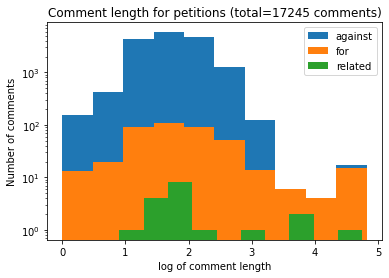

In [103]:
plt.title("Comment length for petitions (total=%d comments)" % len(df))
plt.xlabel("log of comment length")
plt.ylabel("Number of comments")
for status, group in df.groupby('status_manual'):
    plt.hist([np.log10(len(t)) for t in group.comment], label=status)#, log=True)
plt.legend()
plt.yscale('log')
plt.savefig('./figures/comments_length_hist.png', bbox_inches='tight')
plt.show()

(array([1.710e+02, 7.000e+00, 1.900e+01, 4.000e+00, 1.970e+02, 9.900e+01,
        5.460e+02, 6.180e+02, 1.323e+04, 2.354e+03]),
 array([16950.37990741, 17147.93478935, 17345.4896713 , 17543.04455324,
        17740.59943519, 17938.15431713, 18135.70919907, 18333.26408102,
        18530.81896296, 18728.37384491, 18925.92872685]),
 <BarContainer object of 10 artists>)

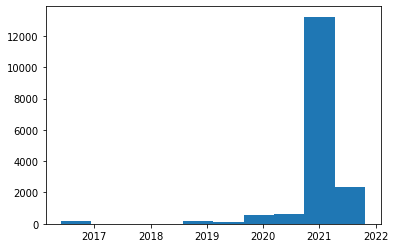

In [80]:
plt.hist(pd.to_datetime(df.created_at))